In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
from underthesea import word_tokenize
from operator import itemgetter
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
#     #xoá khoảng trắng ở đầu và cuối mỗi câu
#     text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
mask1 = df['Human Feedback'] == 'MATCH'

df_pos = df[mask1].reset_index(drop = True)
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"câu 10 : trong hệ trục oxy , cho \ ( \ vec {_u...",câu 18 : trong mặt_phẳng tọa_độ \ ( o x y \ ) ...,231,99,2.333333,242,99,2.444444
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/9fee271...,https://s3.icankid.io/uploads/question/9363c3c...,1995,"bao_nhiêu phần kế_hoạch ? 8 . vào tháng 6 , gi...","8 . vào tháng 6 , giá niêm_yết một chiếc ti vi...",401,90,4.455556,375,86,4.360465


In [7]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = stop_words)

cv_matrix = cv.fit_transform(df_pos['clean_question'])
cv_matrix = pd.DataFrame(cv_matrix.toarray(),
                         columns = cv.get_feature_names())
cv_matrix.shape

(996, 2951)

In [9]:
cv_matrix.head()

,00,000_,004_,00_,01,036_,04_,06,07,08,...,द_,ảnh,ậu,ống,ồm,ổ_cắm,ột,ủp,ứng,ứng_dụng
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def cosine_search_all(queries, cv_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 'cosine_word_count_question'])
    for q in queries:
        query = clean_function(q)
        query_tf = cv.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = cv.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, cv_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['Question Text'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [13]:
result_all = cosine_search_all(df_pos['Lookup Text'], cv_matrix, df_pos)

Time: 29.92079782485962


In [14]:
result_all

,lookup_text,question_text,sim_score,cosine_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.943459,131
1,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.989305,81
2,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.46291,41
3,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.984251,72
4,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.985378,151
...,...,...,...,...
991,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.966092,52
992,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...",Câu 22. Cho đường thẳng \( d: 2 x-y+1=0 \). Để...,0.360041,119
993,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.917061,64
994,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",0.993958,86


In [15]:
df_pos['search_result'] = result_all['question_text']
df_pos['score'] = result_all['sim_score']
df_pos['cosine_word_count_question'] = result_all['cosine_word_count_question']

# df_pos = df_pos[['Feedback ID', 'Lookup Text', 'Question Text', 
#                  'search_result', 'score', 'Feedback Type', 'Human Feedback',
#                  'Lookup Image', 'Question Image']]

In [16]:
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.943459,131
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.989305,81
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.46291,41
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.984251,72
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.985378,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.966092,52
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"câu 10 : trong hệ trục oxy , cho \ ( \ vec {_u...",câu 18 : trong mặt_phẳng tọa_độ \ ( o x y \ ) ...,231,99,2.333333,242,99,2.444444,Câu 22. Cho đường thẳng \( d: 2 x-y+1=0 \). Để...,0.360041,119
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.917061,64
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icanki

In [17]:
mask2 = df_pos['Question Text'] != df_pos['search_result']

df_check = df_pos[mask2]
df_check

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
9,4472.0,5. Một đội thannh nien tinh nguyện có \( 13 \t...,5. Một đội thanh niên tình nguyện có 130 người...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/777c82b...,https://s3.stag.icankids.com.vn/uploads/questi...,23,5 . một đội thannh nien tinh_nguyện có \ ( 13_...,5 . một đội thanh_niên tình_nguyện có 130 ngườ...,154,35,4.400000,140,30,4.666667,Câu 58. (THI HK1 LỚP 11 THPT VIỆT TRÌ 2018 - 2...,0.625,222
12,4496.0,\( \sqrt{3} \sin x+\cos x+\cos 5 x+2(\cos 6 x+...,Đề 117: Giải phương trình: \( \sqrt{3} \sin (x...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/bb4ed6f...,https://s3.icankid.io/uploads/question/bc6bb8a...,31,\ ( \ sqrt { 3_}_\ sin x + \ cos x + \ cos 5 x...,đề 117 : giải phương_trình : \ ( \ sqrt { 3_}_...,97,36,2.694444,134,43,3.116279,15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...,0.847319,28
20,4533.0,Quan sat hai thanh sau:\na) So 0 có phải la bo...,2. Quan sát hai thanh sau:\n\begin{tabular}{|c...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/4d68455...,https://s3.icankid.io/uploads/question/a7ce2dd...,45,quan sat hai thanh sau : a ) so 0 có phải la b...,2 . quan_sát hai thanh sau : \ begin { tabular...,233,61,3.819672,361,105,3.438095,Bài 10: Tim x:\na) \( (x+2)(x-2)-(x-3)(x+5)=0 ...,0.58554,53
24,4543.0,Câu 37. Hàm số nào đồng biến trên khoảng \( (-...,D. Hàm số nghịh bich trểa caic kên khoảng \( (...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f9190b3...,https://s3.icankid.io/uploads/question/9600bf5...,50,câu 37 . hàm_số nào đồng_biến trên khoảng \ ( ...,d . hàm_số nghịh bich trểa caic kên khoảng \ (...,237,76,3.118421,226,72,3.138889,Câu 9. Cho hàm số \( y=\frac{-2 x+3}{x-1} \) c...,0.766131,115
42,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0de11fb...,https://s3.stag.icankids.com.vn/uploads/questi...,79,câu \ ( 2_._\ ) a ) tim tập hơp các ước cuaa 3...,2 ._a ) tìm tập_hợp các ước của 30 ._b ) tìm t...,98,28,3.500000,189,57,3.315789,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,0.3,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,9729.0,b) \( y=x^{4}-3 x^{2}+2 \) trên các đoạn \( [0...,"1. Tính giá trị Iớn nhắt, nhỏ nhất của hàm sô:...",NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f17e1b6...,https://s3.icankid.io/uploads/question/819bc68...,1911,b ) \ ( y_= x ^_{ 4 } - 3 x ^ { 2 } + 2 \ ) tr...,"1_._tính giá_trị iớn nhắt , nhỏ nhất của hàm s...",98,41,2.390244,146,51,2.862745,Câu 9. Cho hàm số \( y=\frac{-2 x+3}{x-1} \) c...,0.65938,115
975,9823.0,Câu 7: Điểm cực tiểu của hàm số \( y=\frac{1}{...,Câu 4: Điểm cực đại của hàm số \( y=\frac{1}{3...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/3e14f2a...,https://s3.icankid.io/uploads/question/a7489c3...,1946,câu 7 : điểm cực_tiểu của hàm_số \ ( y_=_\ fra...,câu 4 : điểm cực_đại của hàm_số \ ( y_=_\ frac...,174,66,2.636364,181,69,2.623188,Câu 39. Cho hàm số \( y=-\frac{1}{3} x^{3}-2 x...,0.727607,95
983,9889.0,\( 4^{3}: 2^{5}+3^{5}: 9^{2} \),b) \( 4^{3}: 2^{5}+3^{5}: 9^{2} \),POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/b4d2f06...,https://s3.icankid.io/uploads/question/5df006c...,1971,\ ( 4 ^ { 3 } : 2 ^ { 5 } + 3 ^ { 5 } : 9 ^ { ...,b ) \ ( 4 ^ { 3 } : 2 ^ { 5 } + 3 ^ { 5 } : 9 ...,53,26,2.038462,57,28,2.035714,"Ví dụ 3: Cho tam giác \( A B C \). Gọi \( M , ...",0.0,153
988,9940.0,d) \( \frac{1}{a-b} \cdot \sqrt{a^{4}(a-b)^{2}...,tâp sau:\nb) \( \frac{1}{a-b} \sqrt{a^{4} \cdo...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/e566bfd...,https://

In [18]:
def cosine_noPCA(query, cv_matrix, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = cv.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = cv.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, cv_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': df_pos.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [19]:
def check_wrong_results(indices):
    index_ = df_check.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_noPCA(df_check.iloc[num]['Lookup Text'], cv_matrix, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check.iloc[num]['Lookup Text'] in top_results) or (df_check.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [20]:
top5_result, no_result = check_wrong_results(list(range(0, len(df_check.index))))

In [21]:
print(len(top5_result))
print(len(no_result))

60
31


In [22]:
mask3 = df_pos['Question Text'] == df_pos['search_result']

df_match = df_pos[mask3]
df_match.shape

(905, 20)

In [23]:
df_top5 = df_pos.iloc[top5_result, :]
df_top5.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
9,4472.0,5. Một đội thannh nien tinh nguyện có \( 13 \t...,5. Một đội thanh niên tình nguyện có 130 người...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/777c82b...,https://s3.stag.icankids.com.vn/uploads/questi...,23,5 . một đội thannh nien tinh_nguyện có \ ( 13_...,5 . một đội thanh_niên tình_nguyện có 130 ngườ...,154,35,4.400000,140,30,4.666667,Câu 58. (THI HK1 LỚP 11 THPT VIỆT TRÌ 2018 - 2...,0.625,222
12,4496.0,\( \sqrt{3} \sin x+\cos x+\cos 5 x+2(\cos 6 x+...,Đề 117: Giải phương trình: \( \sqrt{3} \sin (x...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/bb4ed6f...,https://s3.icankid.io/uploads/question/bc6bb8a...,31,\ ( \ sqrt { 3_}_\ sin x + \ cos x + \ cos 5 x...,đề 117 : giải phương_trình : \ ( \ sqrt { 3_}_...,97,36,2.694444,134,43,3.116279,15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...,0.847319,28
20,4533.0,Quan sat hai thanh sau:\na) So 0 có phải la bo...,2. Quan sát hai thanh sau:\n\begin{tabular}{|c...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/4d68455...,https://s3.icankid.io/uploads/question/a7ce2dd...,45,quan sat hai thanh sau : a ) so 0 có phải la b...,2 . quan_sát hai thanh sau : \ begin { tabular...,233,61,3.819672,361,105,3.438095,Bài 10: Tim x:\na) \( (x+2)(x-2)-(x-3)(x+5)=0 ...,0.58554,53
24,4543.0,Câu 37. Hàm số nào đồng biến trên khoảng \( (-...,D. Hàm số nghịh bich trểa caic kên khoảng \( (...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f9190b3...,https://s3.icankid.io/uploads/question/9600bf5...,50,câu 37 . hàm_số nào đồng_biến trên khoảng \ ( ...,d . hàm_số nghịh bich trểa caic kên khoảng \ (...,237,76,3.118421,226,72,3.138889,Câu 9. Cho hàm số \( y=\frac{-2 x+3}{x-1} \) c...,0.766131,115
42,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0de11fb...,https://s3.stag.icankids.com.vn/uploads/questi...,79,câu \ ( 2_._\ ) a ) tim tập hơp các ước cuaa 3...,2 ._a ) tìm tập_hợp các ước của 30 ._b ) tìm t...,98,28,3.500000,189,57,3.315789,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,0.3,83


In [24]:
df_no = df_pos.iloc[no_result, :]
df_no.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
54,4674.0,\( 2 x-2^{0}=3^{5}: 3^{3} \),f) \( 2 x-2^{0}=3^{5}: 3^{3} \),POSITIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/90ea4e0...,https://s3.icankid.io/uploads/question/91a64b0...,99,\ ( 2 x-2 ^_{ 0 } = 3 ^ { 5 } : 3 ^ { 3 }_\ ),f ) \ ( 2 x-2 ^_{ 0 } = 3 ^ { 5 } : 3 ^ { 3 }_\ ),45,20,2.250000,49,22,2.227273,"Ví dụ 3: Cho tam giác \( A B C \). Gọi \( M , ...",0.0,153
95,4926.0,Fer 1\na) \( x^{2}\left(5 x^{2}-x-\frac{1}{2}\...,1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/ab47cdc...,https://s3.icankid.io/uploads/question/3be66f0...,176,fer 1 a ) \ ( x ^ { 2 }_\_left ( 5 x ^ { 2 } -...,1_. làm tính nhân : a ) \ ( x ^ { 2 }_\_left (...,83,32,2.593750,97,33,2.939394,Bài 2.4. Tìm các số hữu tỉ \( x \) biết:\na) \...,0.981156,135
122,5061.0,Câu 17. Trong mặt phẳng \( Oxy \) cho \( \over...,"Câu 3: Trong mát phẳng toa đô \( O n y \), cho...",NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/bbf8f61...,https://s3.icankid.io/uploads/question/f5c9947...,224,câu 17 . trong mặt_phẳng \ ( oxy_\ ) cho \ ( \...,"câu 3 : trong mát phẳng toa đô \ ( o n y \ ) ,...",284,101,2.811881,296,106,2.792453,Câu 5: Trong mặt phằng \( Oxy \) cho hàm số \(...,0.507833,61
127,5099.0,a) \( x^{2}\left(5 x^{3}-x-\frac{1}{2}\right) \),1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/b967b42...,https://s3.icankid.io/uploads/question/3be66f0...,236,a ) \ ( x ^ { 2 }_\_left ( 5 x ^_{ 3_} - x - \...,1_. làm tính nhân : a ) \ ( x ^ { 2 }_\_left (...,77,28,2.750000,97,33,2.939394,Câu 23. Viết các số theo thứ tự tăng dần: \( \...,0.982946,320
131,5123.0,Cov M Ha tḥp hop các só tư nhiên lón hơn 6 và ...,Luyẹ tạp 3\nGọi \( M \) là tập hợ các số tự nh...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8a2684f...,https://s3.icankid.io/uploads/question/b89da74...,241,cov m ha tḥp hop các só tư_nhiên lón hơn 6 và ...,luyẹ tạp 3 gọi \ ( m \ ) là tập hợ các số tự_n...,95,24,3.958333,201,68,2.955882,Bài 3.(2 điểm) Chlo hai đa thức:\n\[\n\begin{a...,0.340777,134


In [30]:
df_no['Feedback Type'].value_counts()

NEGATIVE    19
POSITIVE    12
Name: Feedback Type, dtype: int64

In [25]:
(df_match.shape[0] + df_top5.shape[0]) / df_pos.shape[0] * 100

96.8875502008032

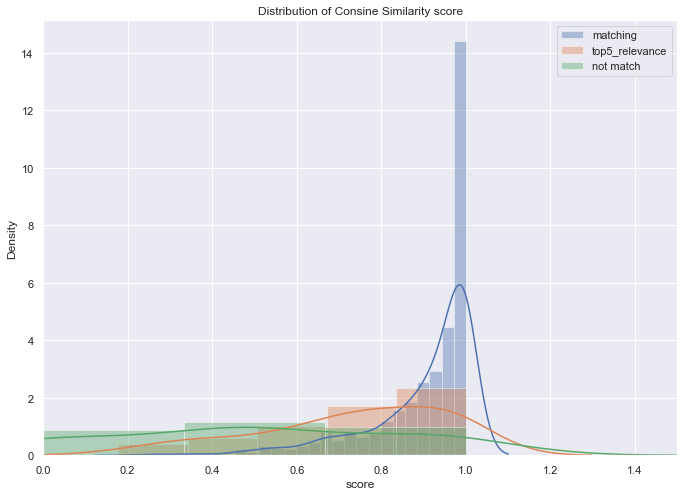

In [26]:
sb.set_theme()
plt.figure(figsize=(25,8))
plt.subplot(121)
sb.distplot(df_match.score, label = 'matching')
plt.subplot(121)
sb.distplot(df_top5.score, label = 'top5_relevance')
plt.subplot(121)
sb.distplot(df_no.score, label = "not match")
plt.xlim([0, 1.5])
plt.legend()
plt.title('Distribution of Consine Similarity score')
plt.show()

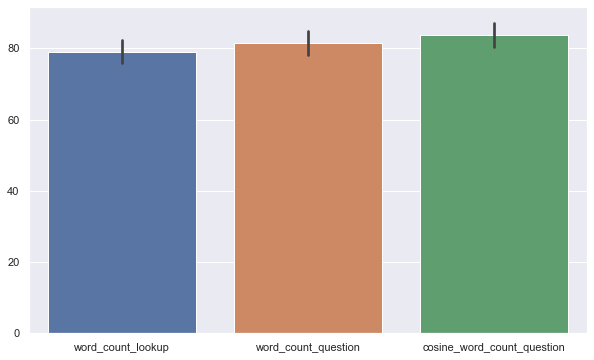

In [27]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_pos[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

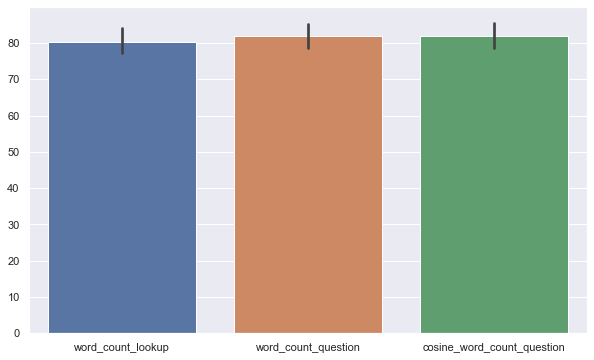

In [28]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_match[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

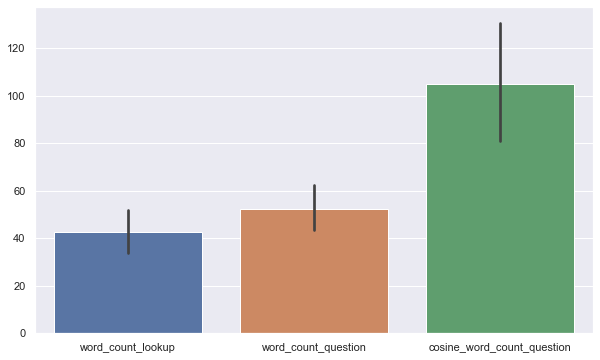

In [29]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_no[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

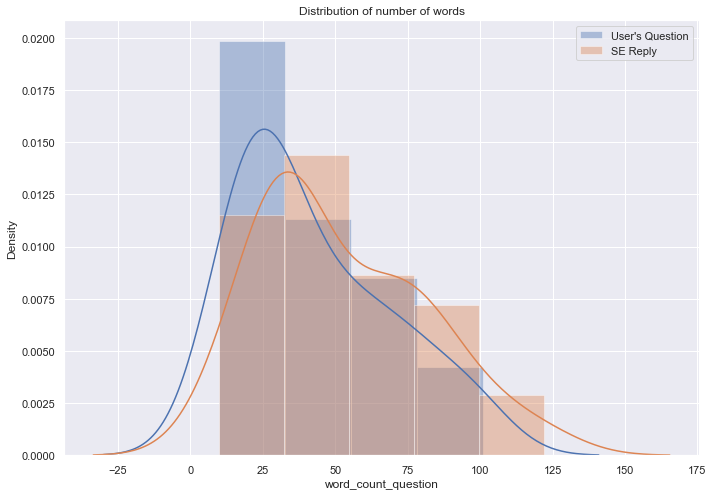

In [36]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_no.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_no.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

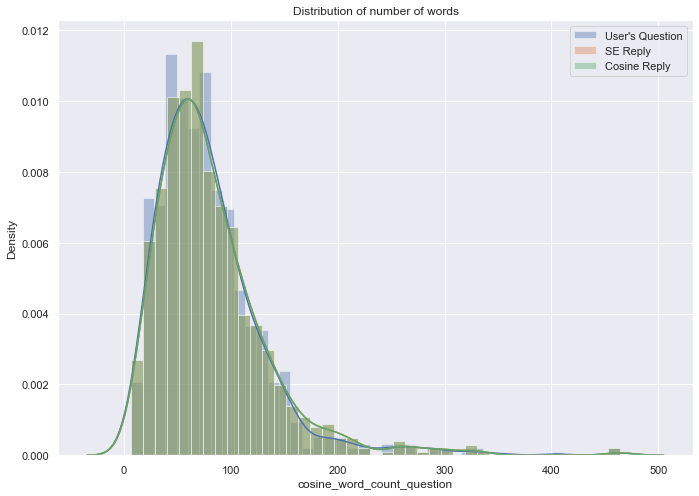

In [40]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_match.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_match.word_count_question, label = "SE Reply")
plt.subplot(121)
sb.distplot(df_match.cosine_word_count_question, label = "Cosine Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

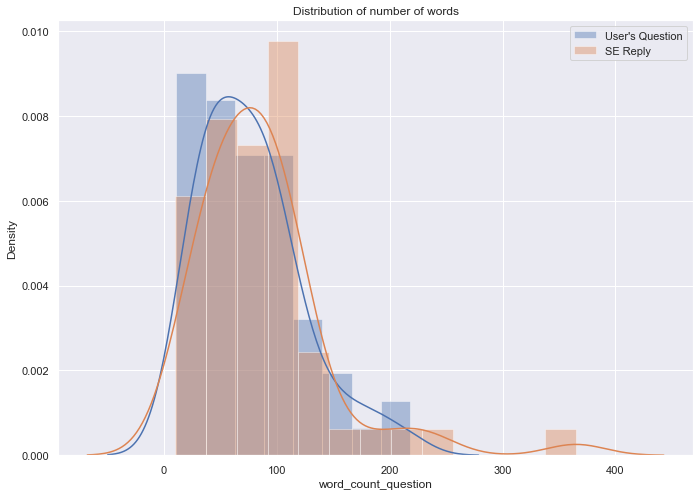

In [38]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_top5.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_top5.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

In [31]:
df_transform = pd.concat([df_pos, ])

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.943459,131
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.989305,81
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.46291,41
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.984251,72
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.985378,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.966092,52
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"câu 10 : trong hệ trục oxy , cho \ ( \ vec {_u...",câu 18 : trong mặt_phẳng tọa_độ \ ( o x y \ ) ...,231,99,2.333333,242,99,2.444444,Câu 22. Cho đường thẳng \( d: 2 x-y+1=0 \). Để...,0.360041,119
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.917061,64
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icanki

In [32]:
cv_matrix

,00,000_,004_,00_,01,036_,04_,06,07,08,...,द_,ảnh,ậu,ống,ồm,ổ_cắm,ột,ủp,ứng,ứng_dụng
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
sums = cv_matrix.sum().sort_values(ascending = False)
sums.head(30)

frac        1134
sqrt         520
_right       384
a_           384
_left        355
3_           265
câu          228
10           221
y_           218
cdot         203
_b           203
_a           200
circ         170
hai          166
_c           163
sin          135
pi           128
2_           128
tập_hợp      123
cos          114
1_           113
hàm_số       111
viết         108
12           103
_tính        101
left         100
15            94
_cdot         92
mệnh_đề       91
tam_giác      86
dtype: int64

In [ ]:
df_no

In [ ]:
index_ = 95

In [ ]:
df_pos.iloc[index_]['Lookup Text']

In [ ]:
df_pos.iloc[index]['Question Text']

In [ ]:
df_pos.iloc[index]['search_result']